In [1]:
%run ../config/init.py
import pandas
import networkx as nx
import matplotlib.patches as mpatches
from goenrichment.enrichment import calculate
from goenrichment.go import load_goenrichdb
from goenrichment.graph import ancestors

## Loading Human Gene2GO database from NCBI FTP

In [2]:
goenrichDB = "ftp://ftp.ncbi.nlm.nih.gov/pub/goenrichment/goenrichDB_human.pickle"
godb = load_goenrichdb(goenrichDB)
print('There are %d alternative ids in database' % (len(godb['alt_id'])))
print('There are %d GO terms' % (len(godb['graph'].node)))
print('There are %d genes in database' % (godb['M']))

Loading go enrichment DB from: ftp://ftp.ncbi.nlm.nih.gov/pub/goenrichment/goenrichDB_human.pickle
There are 2375 alternative ids in database
There are 45006 GO terms
There are 39810 genes in database


## Loading DGA results file

In [3]:
comparisons = [
    ['classical', 'nonclassical']
]
data_dir = os.path.join(RESULTS, DATASET, 'dga')
result_dir = os.path.join(RESULTS, DATASET, 'go')
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
os.chdir(result_dir)

### Go enrichment parameters

In [4]:
min_category_depth=4
min_category_size=3
max_category_size=500

Processing classical vs nonclassical
	Processing 484 over expressed gene list
	Processing 691 under expressed gene list
	GO namespace: cellular_component
		GO terms for genes over expressed: 15
		GO terms for genes under expressed: 36


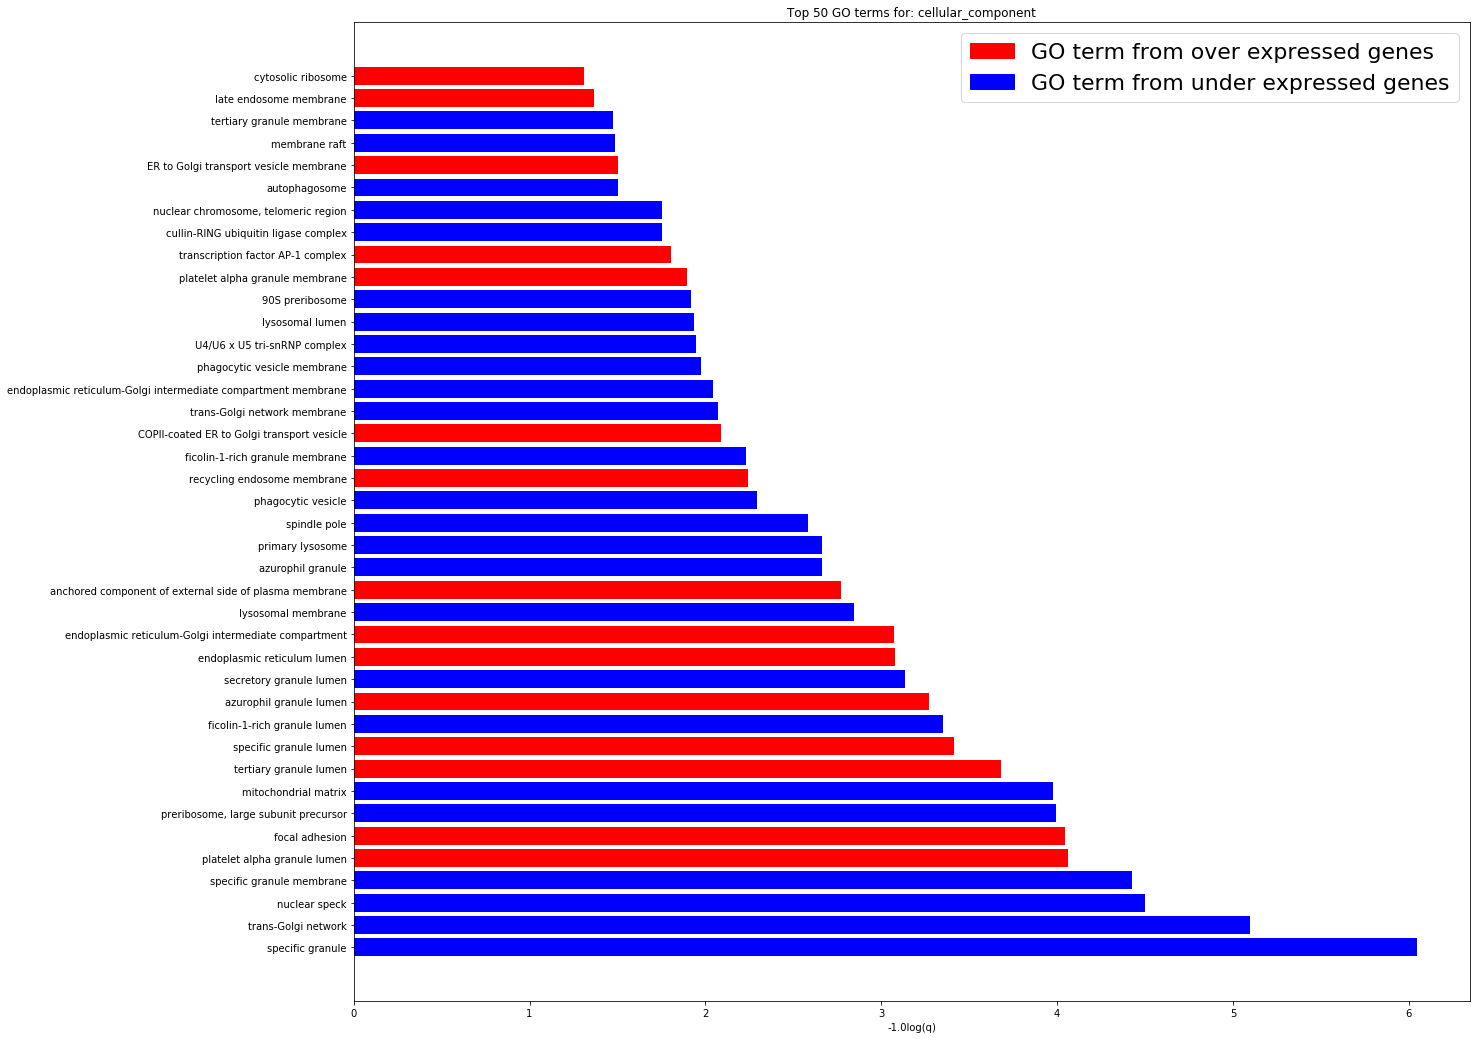

	GO namespace: molecular_function
		GO terms for genes over expressed: 53
		GO terms for genes under expressed: 26


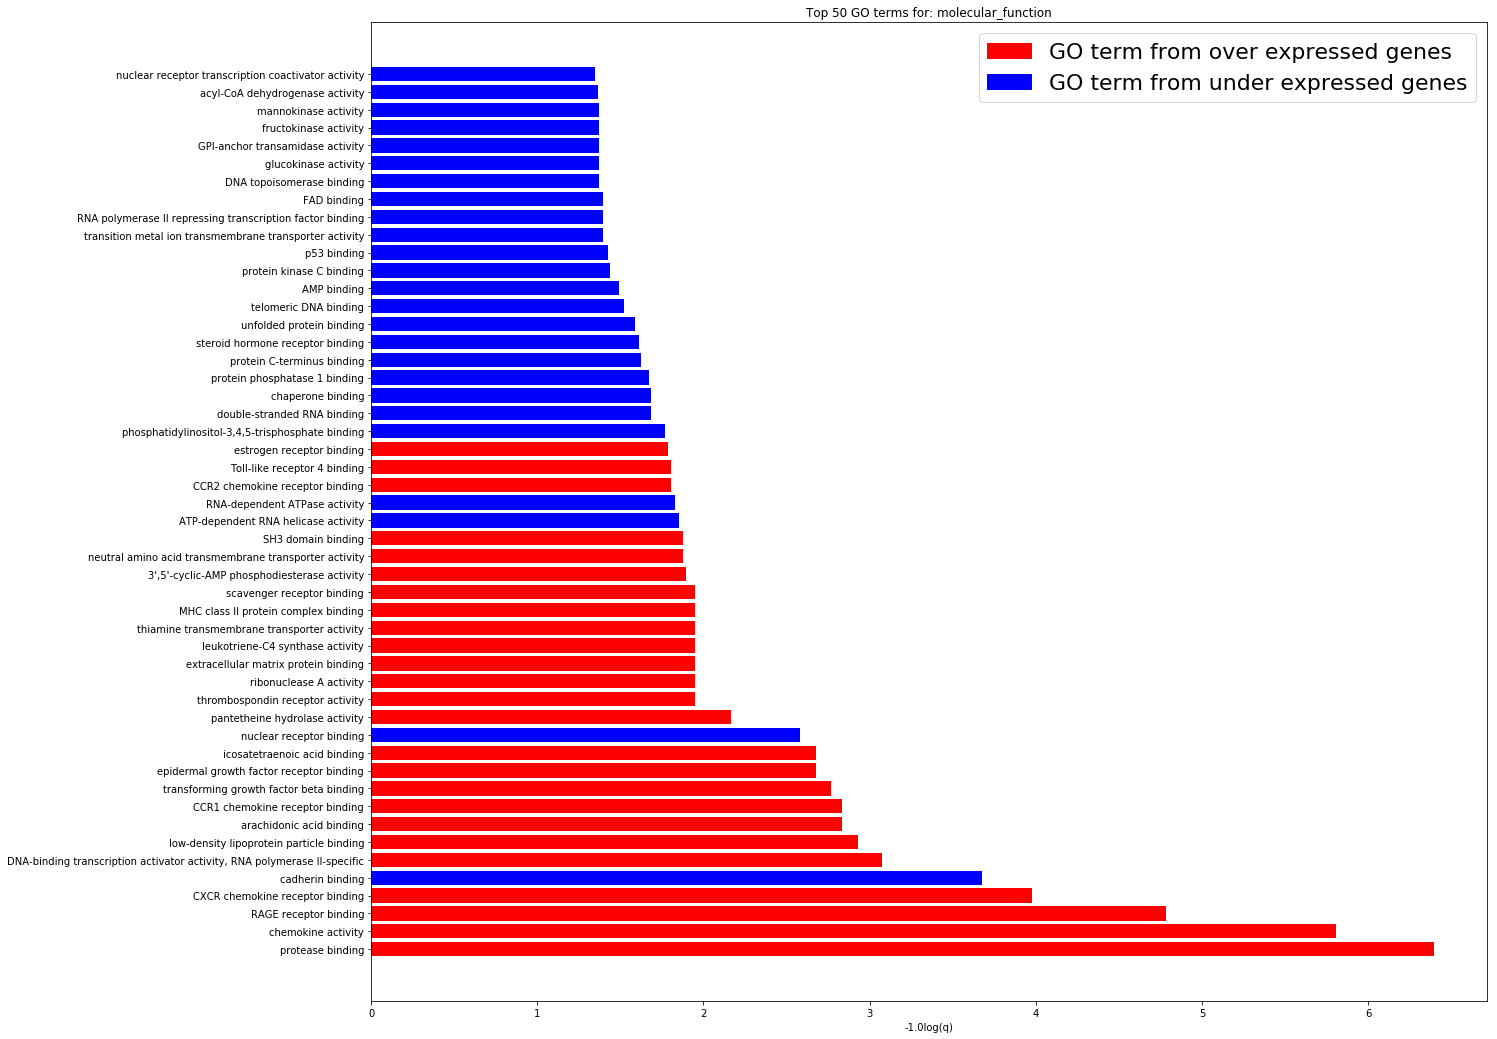

	GO namespace: biological_process
		GO terms for genes over expressed: 262
		GO terms for genes under expressed: 156


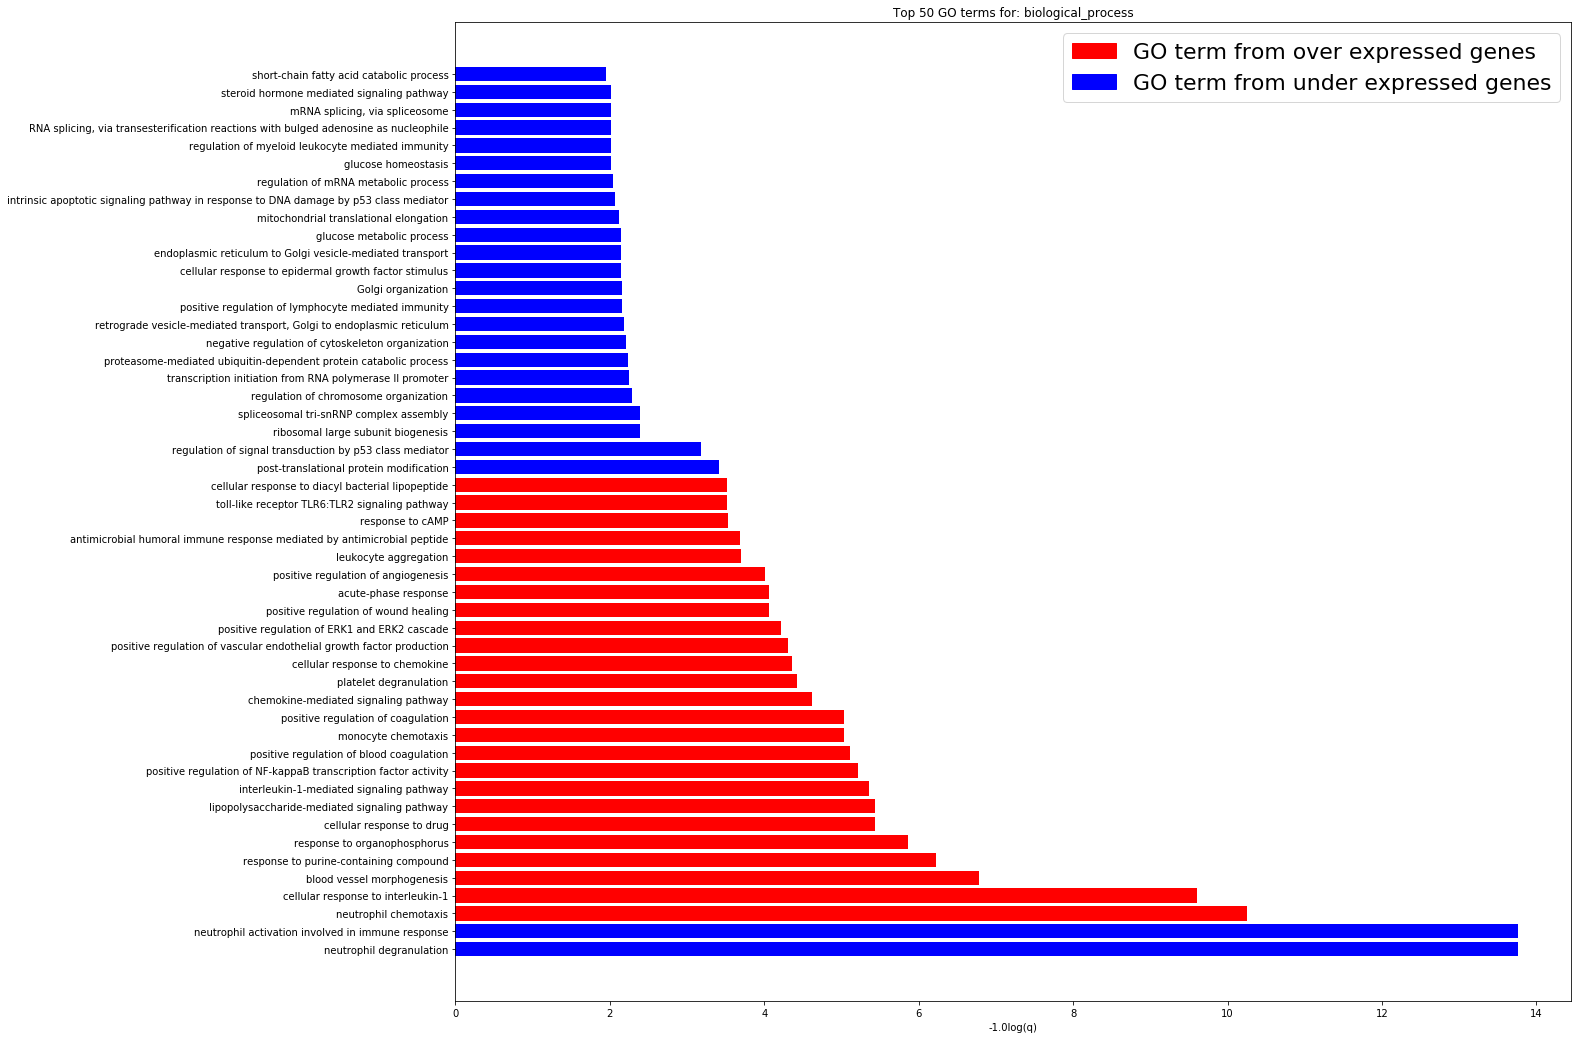

In [5]:
for c in comparisons:
    print('Processing %s vs %s' % (c[0], c[1]))
    dga_file = os.path.join(data_dir, 'condition_{0}_vs_{1}_union.csv'.format(c[0], c[1]))
    if os.path.exists(dga_file):
        dga_df = pandas.read_csv(dga_file)
        dga_df['Gene_Id'], dga_df['Chr'], dga_df['start'] = dga_df['Gene_Id'].str.split('_',2).str
        query = set(dga_df[(dga_df['FDR'] <= fdr)&(dga_df['logFC'] >= fc)]['Gene_Id'].tolist())
        print('\tProcessing {0} over expressed gene list'.format(len(query)))
        over_df = calculate(godb, query, fdr, min_category_depth, min_category_size, max_category_size)
        over_df = over_df[over_df['q'] <= fdr]        
        
        query = set(dga_df[(dga_df['FDR'] <= fdr)&(dga_df['logFC'] <= -1.0 * fc)]['Gene_Id'].tolist())
        print('\tProcessing {0} under expressed gene list'.format(len(query)))
        under_df = calculate(godb, query, fdr, min_category_depth, min_category_size, max_category_size)
        under_df = under_df[under_df['q'] <= fdr]
        
        over_df = over_df[~over_df['term'].isin(under_df['term'])].sort_values('q')
        under_df = under_df[~under_df['term'].isin(over_df['term'])].sort_values('q')
        
        for d in set().union(over_df['namespace'].unique(), under_df['namespace'].unique()): 
            print('\tGO namespace: ' + d)
            df1 = over_df[over_df['namespace'] == d]
            file_name = 'go_over_{0}_{1}_vs_{2}_union.csv'.format(d, c[0], c[1])
            df1.to_csv(file_name, index=None)
            print('\t\tGO terms for genes over expressed: %d' % len(df1))
            df2 = under_df[under_df['namespace'] == d]
            file_name = 'go_under_{0}_{1}_vs_{2}_union.csv'.format(d, c[0], c[1])
            df2.to_csv(file_name, index=None)
            print('\t\tGO terms for genes under expressed: %d' % len(df2))
            
            if len(df1) > 25:
                df1 = df1.head(25)
            if len(df2) > 25:
                df2 = df2.head(25)
            df1 = df1.reset_index(drop=True)
            df1['color'] = 'red'    
            df2 = df2.reset_index(drop=True)
            df2['color'] = 'blue'
            df = pandas.concat([df1, df2])
            df = df.sort_values('q')
            
            plt.subplots(figsize=(20,18))
            objects = df['name'].tolist()
            x_pos = np.arange(len(objects))
            counts = df['-1.0log(q)'].tolist()
            colors = df['color'].tolist()
            plt.barh(x_pos, counts, align='center', color=colors)
            plt.yticks(x_pos, objects)
            plt.xlabel('-1.0log(q)')
            plt.title('Top 50 GO terms for: ' + d)
            red_patch = mpatches.Patch(color='red', label='GO term from over expressed genes')
            blue_patch = mpatches.Patch(color='blue', label='GO term from under expressed genes')
            plt.legend(handles=[red_patch, blue_patch], prop={'size': 22})
            file_name = 'go_{0}_{1}_vs_{2}_union.png'.format(d, c[0], c[1])
            plt.savefig(file_name, bbox_inches = "tight")
            plt.show()